In [1]:
%load_ext autoreload
%autoreload 2

import jax.numpy as jnp
import numpy as np
import optax
import random
import gym
import jax.random as jrandom
from jax import vmap, jit
import matplotlib.pyplot as plt

from replay_buffer import ReplayBuffer
from constants import SEED
from policy import policy_grad, lr_gradients, get_sequence_rewards, get_trajectory_distrib, trajectory_value2
from pilco_utils import get_trajectories, rollout_episode, get_trajectory2
from rff import phi_X, phi_X_batch
from trans_model import prior, train_transition_models, predict, lklhood_grad, marg_lklhood, trans_output
from neural_nets import get_params

In [2]:
env = gym.make('InvertedPendulum-v4')
state_dim = env.observation_space.shape[0]

/Users/damso/Year4/FYP/pipps/venv/lib/python3.7/site-packages/gym/utils/env_checker.py:145: UserWarning: WARN: Agent's minimum observation space value is -infinity. This is probably too low.
  "Agent's minimum observation space value is -infinity. This is probably too low."
/Users/damso/Year4/FYP/pipps/venv/lib/python3.7/site-packages/gym/utils/env_checker.py:149: UserWarning: WARN: Agent's maxmimum observation space value is infinity. This is probably too high
  "Agent's maxmimum observation space value is infinity. This is probably too high"
/Users/damso/Year4/FYP/pipps/venv/lib/python3.7/site-packages/gym/utils/env_checker.py:201: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


### Run random policy to collect training data

In [4]:
INIT_EPISODES = 100
BUFFER_CAPACITY = 1000
HORIZON = 30

replay_buffer = ReplayBuffer(capacity=BUFFER_CAPACITY)

for ep in range(INIT_EPISODES):
    cur_state = env.reset()
    done = False
    
    for t in range(HORIZON):
        action = np.array([random.uniform(-1., 1.)])
        prev_state = cur_state

        cur_state, _, done, _ = env.step(action)
        replay_buffer.push(prev_state, action.squeeze(), cur_state)


print(len(replay_buffer))

3000


### Compute posterior distribution for transition models

In [11]:
theta = jnp.full((state_dim + 1,), .9)
BETAS = jnp.full((4,), 20.)
MODEL_NOISES = jnp.array([0.3, 0.3, 1., 3.])
ALPHA = .3
N = 1000
NUM_FEATURES = 3

model_d1 = prior(NUM_FEATURES, alpha=ALPHA)
model_d2 = prior(NUM_FEATURES, alpha=ALPHA)
model_d3 = prior(NUM_FEATURES, alpha=ALPHA)
model_d4 = prior(NUM_FEATURES, alpha=ALPHA)

trans_models_pre = [model_d1, model_d2, model_d3, model_d4]
trans_models_post = train_transition_models(
    replay_buffer, BETAS, trans_models_pre, NUM_FEATURES
)

[[5.1537761e-05 4.7013907e-07 2.8116731e-06]
 [4.7013904e-07 4.9886119e-05 8.4992621e-07]
 [2.8116731e-06 8.4992621e-07 1.6832753e-05]]


### Optimise Transition Model Parameters

In [ ]:
key = SEED
cur_keys = jrandom.split(key, num=3)
N = 1000
SEQ_LEN = 20

transitions = replay_buffer.memory[:SEQ_LEN]
states = jnp.array(list(map(lambda t: t.state, transitions)))
actions = jnp.array(list(map(lambda t: t.action, transitions)))
next_states = jnp.array(list(map(lambda t: t.next_state, transitions)))

params = jnp.array([coefs])
optimizer = optax.chain(
    optax.adam(learning_rate=0.06),
    optax.scale(-1.0)
)
opt_state = optimizer.init(params)

for i in range(35):
    trans = jrandom.normal(cur_keys[0], shape=(N, SEQ_LEN, 4))
    omega = jrandom.normal(cur_keys[1], shape=(N, NUM_FEATURES, 2))
    phi = jrandom.uniform(cur_keys[2], minval=0, maxval=2 * jnp.pi, shape=(N, NUM_FEATURES, 1))

    grads = lklhood_grad(states, NUM_FEATURES, lengthscales, params[0], BETAS, MODEL_NOISE, 2, actions, next_states, trans, omega, phi, *trans_models_post)

    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    if i % 5 == 0:
        objective = marg_lklhood(states, NUM_FEATURES, lengthscales, params[0], BETAS, MODEL_NOISE, actions, next_states, trans, omega, phi, *trans_models_post)
        print(f"Step {i}, objective: {objective}")

np.save('optimal_coefs.npy', np.asarray(params[0]))

### Test Next State Predictions

In [13]:
action = jnp.array([.5])
N = 1000

@jit
def pred(start_st, state_eps, trans_eps, betas, m_d1, m_d2, m_d3, m_d4):
    model_input = jnp.stack([start_st, jnp.full((4,), action), jnp.ones((4,))]).T
    L1 = jnp.linalg.cholesky(m_d1[1])
    L2 = jnp.linalg.cholesky(m_d2[1])
    L3 = jnp.linalg.cholesky(m_d3[1])
    L4 = jnp.linalg.cholesky(m_d4[1])

    w_d1 = m_d1[0] + L1 @ trans_eps[0]
    w_d2 = m_d2[0] + L2 @ trans_eps[1]
    w_d3 = m_d3[0] + L3 @ trans_eps[2]
    w_d4 = m_d4[0] + L4 @ trans_eps[3]
    
    state_diff = trans_output(w_d1, w_d2, w_d3, w_d4, model_input)
    next_mean = state_diff + start_st
    next_state = next_mean + state_eps * (betas ** -0.5)
    return next_state

def state_prediction(start_state, state_epsilons, trans_epsilons, betas, model_noise, trans_models):
    foo = vmap(pred, (None, 0, 0, None, None, None, None, None))
    predictions = foo(
        start_state, state_epsilons, trans_epsilons, betas, *trans_models
    )

    return predictions

keys = jrandom.split(SEED, num=4)
state_eps = jrandom.normal(keys[0], shape=(N, 4))
trans_eps = jrandom.normal(keys[1], shape=(N, 4, NUM_FEATURES))


predictions_post = state_prediction(
    jnp.zeros((4,)), state_eps, trans_eps, BETAS, MODEL_NOISES, trans_models_post
    ).mean(axis=0)
print(f"Pred: {predictions_post}")
print(f"True: {env.step(action)[0]}")

Pred: [ 0.00402927  0.00411775  0.1416773  -0.22677861]
True: [ 9.89750436e-01 -1.57318776e+00  3.61875913e-02  1.27797200e-05]


In [14]:
transitions = replay_buffer.memory
states = jnp.array(list(map(lambda t: t.state, transitions)))
actions = jnp.array(list(map(lambda t: t.action, transitions)))
next_states = jnp.array(list(map(lambda t: t.next_state, transitions)))

N = 10000
key = SEED
keys = jrandom.split(key, num=4)
num_states = len(transitions) 
pred_next_states = np.zeros((num_states, 4))

for i, start_state in enumerate(states):
    state_eps = jrandom.normal(keys[0], shape=(N, 4))
    trans_eps = jrandom.normal(keys[1], shape=(N, 4, NUM_FEATURES))

    pred_st = state_prediction(
        start_state, state_eps, trans_eps, BETAS, MODEL_NOISES, trans_models_post
    ).mean(axis=0)
    pred_next_states[i] = pred_st

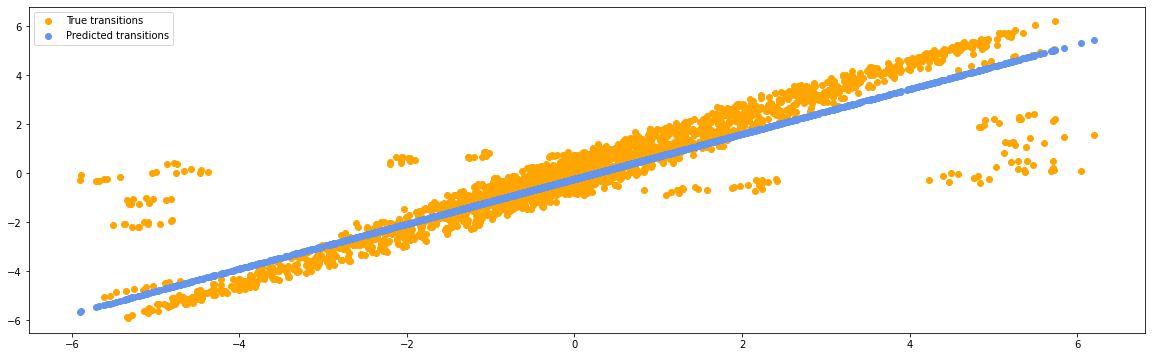

In [18]:
plt.figure(figsize=(20, 6))
plt.scatter(states[:, 3], next_states[:, 3], color='orange', label="True transitions")
plt.scatter(states[:, 3], pred_next_states[:, 3], color='cornflowerblue', label="Predicted transitions")
plt.legend()
plt.show()

### Compute Policy Gradients

In [38]:
params = get_params(SEED)
BETAS = jnp.full((4,), 1.)
ALPHA = 0.3
N = 10000
HORIZON = 10
NUM_FEATURES = 3

model_d1 = prior(NUM_FEATURES, alpha=ALPHA)
model_d2 = prior(NUM_FEATURES, alpha=ALPHA)
model_d3 = prior(NUM_FEATURES, alpha=ALPHA)
model_d4 = prior(NUM_FEATURES, alpha=ALPHA)

trans_models = [model_d1, model_d2, model_d3, model_d4]

trans_models_post = train_transition_models(replay_buffer, BETAS, trans_models, NUM_FEATURES)

model_d1, model_d2, model_d3, model_d4 = trans_models_post

key = SEED
key, subkey = jrandom.split(key)
subkeys = jrandom.split(subkey, num=2)
state_epsilons = jrandom.normal(key=subkeys[0], shape=(N, HORIZON, 4))
trans_epsilons = jrandom.normal(key=subkeys[1], shape=(N, HORIZON, 4, NUM_FEATURES))

# LR gradients
trajectories = get_trajectories(
    params, BETAS, env, *trans_models_post, HORIZON, state_epsilons, trans_epsilons
    )
lr_grads = lr_gradients(
    params, BETAS, *trans_models_post, HORIZON, trajectories, trans_epsilons,
    )
print(f"LR: {lr_grads['mlp/~/linear_0']['w'][0, :6]}")

# # RP gradients
rp_grads = policy_grad(
        params, BETAS, *trans_models_post, env, HORIZON, state_epsilons, trans_epsilons,
    )
print(f"RP: {rp_grads['mlp/~/linear_0']['w'][0, :6]}")

LR: [ 0.0015753  -0.01135863 -0.00134087  0.00187886 -0.00544714 -0.00062965]
RP: [ 0.00126804 -0.0075538  -0.00159109  0.00131166 -0.00421244 -0.00093829]


### Variance Computation

In [ ]:
num_runs = 10
lr_gradients_w0 = np.zeros((num_runs, 256))
lr_gradients_b0 = np.zeros((num_runs, 256))
rp_gradients_w0 = np.zeros((num_runs, 256))
rp_gradients_b0 = np.zeros((num_runs, 256))

key = SEED
for k in range(num_runs):
    key, subkey = jrandom.split(key)
    subkeys = jrandom.split(subkey, num=2)
    state_epsilons = jrandom.normal(key=subkeys[0], shape=(N, HORIZON, 4))
    trans_epsilons = jrandom.normal(key=subkeys[1], shape=(N, HORIZON, 4, NUM_FEATURES))

    # LR gradients
    trajectories, trans_predictions = get_trajectories(
        params, BETAS, env, *trans_models_post, HORIZON, state_epsilons, trans_epsilons
        )
    lr_grads = lr_gradients(
        params, BETAS, *trans_models_post, HORIZON, trajectories, trans_predictions, trans_epsilons,
        )
    
    lr_gradients_w0[k] = lr_grads['mlp/~/linear_1']['w'].reshape(-1) 
    lr_gradients_b0[k] = lr_grads['mlp/~/linear_1']['b']

    rp_grads = policy_grad(
        params, BETAS, *trans_models_post, env, HORIZON, state_epsilons, trans_epsilons,
    )
    rp_gradients_w0[k] = rp_grads['mlp/~/linear_1']['w'].reshape(-1) 
    rp_gradients_b0[k] = rp_grads['mlp/~/linear_1']['b']


print(f"LR var - weights: {lr_gradients_w0.var(axis=0).mean()}, bias: {lr_gradients_b0.var(axis=0).mean()}")
print(f"RP var - weights: {rp_gradients_w0.var(axis=0).mean()}, bias: {rp_gradients_b0.var(axis=0).mean()}")


### Particle-based PILCO

In [ ]:
MAX_EPISODES = 200
NOISE = 0.3
HORIZON = 10
TEST_HORIZON = 300
N = 1000
TRAIN_LOOPS = 10
key = SEED

trans_models = trans_models_post

params = get_params(key)

objectives = np.zeros((MAX_EPISODES,))

# schedule = optax.exponential_decay(
#     init_value=0.0005,
#     transition_steps=100 * TRAIN_LOOPS,
#     decay_rate=0.999,
#     transition_begin=900,
#     staircase=False
# )
optimizer = optax.chain(
    optax.adam(learning_rate=0.00005),
    # optax.scale(-1.0)
)

opt_state = optimizer.init(params)

subkeys = jrandom.split(key, num=6)
for ep in range(MAX_EPISODES):
    key = subkeys[0]

    state_epsilons = jrandom.normal(key=subkeys[1], shape=(N, HORIZON, 4))
    trans_epsilons = jrandom.normal(key=subkeys[2], shape=(N, HORIZON, 4, NUM_FEATURES))

    model_d1 = prior(NUM_FEATURES, alpha=ALPHA)
    model_d2 = prior(NUM_FEATURES, alpha=ALPHA)
    model_d3 = prior(NUM_FEATURES, alpha=ALPHA)
    model_d4 = prior(NUM_FEATURES, alpha=ALPHA)

    trans_models = [model_d1, model_d2, model_d3, model_d4]

    # Train model with all available data
    trans_models = train_transition_models(replay_buffer, BETAS, trans_models, NUM_FEATURES)

    for _ in range(TRAIN_LOOPS):
        # Compute the policy gradient
        # trajectories, trans_predictions = get_trajectories(
        #     params, BETAS, env, *trans_models, HORIZON, NOISE, state_epsilons, trans_epsilons
        #     )
        # grads = lr_gradients(
        #     params, BETAS, *trans_models, HORIZON, NOISE, trajectories, trans_predictions, trans_epsilons,
        #     )

        # RP gradients
        grads = policy_grad(
            params,
            BETAS,
            *trans_models,
            env,
            HORIZON,
            state_epsilons,
            trans_epsilons,
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)

    # Roll-out policy online for a few episode and add to replay buffer
    cur_obj = 0
    for j in range(5):
        cur_obj += rollout_episode(env, TEST_HORIZON, replay_buffer, params)
    cur_obj /= 5
    objectives[ep] = cur_obj

    if ep % 10 == 0:
        # print(f"Ep {ep}, objective: {cur_obj}, theta: {theta}")
        print(f"Ep {ep}, objective: {cur_obj}")

final_obj = rollout_episode(env, TEST_HORIZON, replay_buffer, params)
print(f"Final score: {final_obj}")
